In [1]:
%matplotlib inline

In [2]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
import scipy.integrate
import scipy.interpolate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
import os
import multiprocessing
import json
# For parallelization
from joblib import Parallel, delayed

import lmfit
import nekhoroshev_tools as nt

from working_experiment_script.working_experiment_functions import *

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'+"\n"+r"\usepackage{graphicx}"

In [4]:
FIGPATH = "ext_figs/"

In [5]:
#FIGPATH = "../PAPER_DIFFUSION/figs/"

In [6]:
FIGPATH

'ext_figs/'

In [7]:
figsize = (7, 4)
figsize_compressed = (7, 4)
figsize_large = (7, 5)

In [8]:
with open("working_experiment_script/full_dict.pkl", 'rb') as f:
    full_dict = pickle.load(f)

In [9]:
print("Before deletion: ", full_dict.keys())
to_delete = []
for i in full_dict:
    if len(full_dict[i]) < 3:
        to_delete.append(i)
for i in to_delete:    
    del full_dict[i]
print("After deletion: ", full_dict.keys())

Before deletion:  dict_keys([28.000000000000004, 10.0, 10.000000000000002, 12.000000000000002, 14.0, 14.000000000000004, 16.0, 16.000000000000007, 18.000000000000004, 20.0, 20.000000000000004, 22.0, 22.000000000000007, 24.0, 24.000000000000007, 26.0, 26.000000000000007, 28.000000000000007, 30.0, 4.0, 6.000000000000001, 8.0, 8.000000000000002])
After deletion:  dict_keys([28.000000000000004, 10.0, 12.000000000000002, 14.0, 16.0, 18.000000000000004, 20.0, 22.0, 24.0, 26.0, 30.0, 4.0, 6.000000000000001, 8.0])


In [10]:
print("I_max positions: ", full_dict.keys())
print("barrier steps: ", full_dict[8.0].keys())
print("fraction considered: ", full_dict[8.0][1.0].keys())
print("Data filters available: ", full_dict[10.0][1.0][0.5].keys())
print("Fit kinds: ", full_dict[10.0][1.0][0.5][np.inf, 0.5].keys())
print("Accessing data: ")
full_dict[10.0][1.0][0.5][np.inf, 0.5]["forward_only"].params


I_max positions:  dict_keys([28.000000000000004, 10.0, 12.000000000000002, 14.0, 16.0, 18.000000000000004, 20.0, 22.0, 24.0, 26.0, 30.0, 4.0, 6.000000000000001, 8.0])
barrier steps:  dict_keys([0.02, 0.1, 0.2, 1.0])
fraction considered:  dict_keys([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0])
Data filters available:  dict_keys(['info', (inf, 0.001), (inf, 0.005), (inf, 0.01), (inf, 0.05), (inf, 0.1), (inf, 0.5)])
Fit kinds:  dict_keys(['forward_only'])
Accessing data: 


name,value,standard error,relative error,initial value,min,max,vary
I_star,20.1671360,0.08038831,(0.40%),20.0,0.10000000,inf,True
k,0.34589599,0.00291394,(0.84%),0.33,0.00000000,inf,True
c,330.998299,0.00000000,(0.00%),330.99829890330193,-inf,inf,False


In [11]:
print(full_dict[10.0][1.0][0.5][np.inf, 0.5]["forward_only"].params["k"].value)
print(full_dict[10.0][1.0][0.5][np.inf, 0.5]
      ["forward_only"].params["I_star"].value)


0.34589599307853125
20.16713601751361


In [12]:
# get the position of the first decimal digit in a number
def get_first_decimal_digit(x):
    if np.isnan(x):
        return np.nan
    return int(np.floor(np.log10(np.absolute(x))))

In [13]:
get_first_decimal_digit(-0.01)

-2

In [14]:
# format a double number to a string with a certain number of decimals
def format_double(x):
    if np.isnan(x):
        return "nan"
    return "{:.{}f}".format(x, np.absolute(get_first_decimal_digit(x)))

In [15]:
max_err = 0.2
max_err_color = 0.1
vmin = 0.0
vmax = 0.2
def printer(num):
    if np.absolute(num) > 1:
        return "${:.1f}$".format(np.absolute(num))
    elif np.absolute(num) > max_err:
        return "${:.2f}$".format(np.absolute(num))
    elif np.absolute(num) >= 0.01:
        return "${:.2f}$".format(np.absolute(num))
    else:
        return "$" + format_double(np.absolute(num)) + "$"

def color(num):
    # if num is greater than max_err, print it in black
    if np.absolute(num) > max_err_color:
        return "black"
    else:
        return "white"


# Plotting all fit results

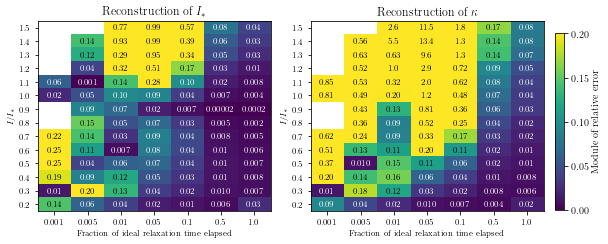

In [16]:
I_max_list = list(sorted([10.0, 12.000000000000002, 14.0, 16.0, 18.000000000000004, 20.0, 22.0, 24.0, 26.0, 28.000000000000004, 30.0, 4.0, 6.000000000000001, 8.0]))
b_step = 0.1
fraction_list = list(sorted([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]))
f = (np.inf, 0.1)
f_bis = (1.0, 0.1)
fit_kind = "forward_only"

the_data_k = np.empty((len(I_max_list), len(fraction_list))) * np.nan
the_data_I = np.empty((len(I_max_list), len(fraction_list))) * np.nan

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))

for i, I_max in enumerate(I_max_list):
    for j, fraction in enumerate(fraction_list):
        tmp = full_dict[I_max][b_step][fraction]
        if f in tmp:
            if fit_kind in tmp[f] and type(tmp[f][fit_kind]) != str:
                the_data_I[i, j] = tmp[f][fit_kind].params["I_star"].value / 20.0 - 1
                the_data_k[i, j] = tmp[f][fit_kind].params["k"].value / 0.33 - 1

im = ax.imshow(
    np.absolute(the_data_I), 
    origin="lower",
    aspect="auto", 
    vmin=vmin, vmax=vmax
)

ax.set_yticks(np.arange(0, len(the_data_I), 1))
ax.set_yticklabels(["{:.1f}".format(x/20.0) for x in I_max_list], fontsize="small")
ax.set_xticks(np.arange(0, len(the_data_I[0]), 1))
ax.set_xticklabels(["{}".format(x) for x in fraction_list], fontsize="small")

ax.set_xlabel("Fraction of ideal relaxation time elapsed", fontsize="small")
ax.set_ylabel("$I / I_\\ast$", fontsize="small")
ax.set_title("Reconstruction of $I_\\ast$")

ax2.imshow(
    np.absolute(the_data_k), 
    origin="lower", 
    aspect="auto", 
    vmin=vmin, vmax=vmax
)

ax2.set_yticks(np.arange(0, len(the_data_I), 1))
ax2.set_yticklabels(["{:.1f}".format(x/20.0) for x in I_max_list], fontsize="small")
ax2.set_xticks(np.arange(0, len(the_data_I[0]), 1))
ax2.set_xticklabels(["{}".format(x) for x in fraction_list], fontsize="small")

ax2.set_xlabel("Fraction of ideal relaxation time elapsed", fontsize="small")
ax2.set_ylabel("$I / I_\\ast$", fontsize="small")
ax2.set_title("Reconstruction of $\\kappa$")

for j in range(len(fraction_list)):
    for i in range(len(I_max_list)):
        ax.text(j, i, printer(
            the_data_I[i, j]), ha="center", va="center", fontsize="small", color=color(the_data_I[i, j]))

for j in range(len(fraction_list)):
    for i in range(len(I_max_list)):
        ax2.text(j, i, printer(
            the_data_k[i, j]), ha="center", va="center", fontsize="small", color=color(the_data_k[i, j]))

plt.tight_layout()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.015, 0.7])

bar = fig.colorbar(im, cax=cbar_ax, label="Module of relative error")
bar.set_ticks([0.0, 0.05, 0.10, 0.15, 0.20])

plt.savefig(os.path.join(FIGPATH, "MULTI_different_time.pdf"), dpi=600, bbox_inches='tight')
plt.savefig(os.path.join(FIGPATH, "MULTI_different_time.png"), dpi=600, bbox_inches='tight', facecolor="white")
plt.savefig(os.path.join(FIGPATH, "MULTI_different_time.jpg"), dpi=600, bbox_inches='tight')


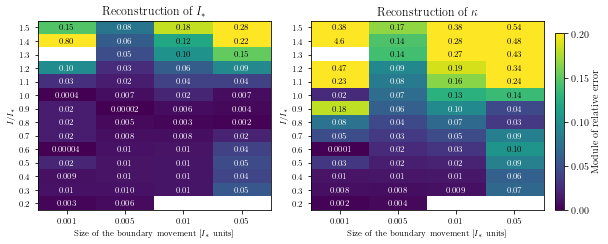

In [17]:
I_max_list = list(sorted([10.0, 12.000000000000002, 14.0, 16.0, 18.000000000000004, 20.0, 22.0, 24.0, 26.0, 28.000000000000004, 30.0, 4.0, 6.000000000000001, 8.0]))
b_step_list = list(sorted([0.02, 0.1, 0.2, 1.0]))
fraction = 0.5
f = (np.inf, 0.1)
fit_kind = "forward_only"

the_data_k = np.empty((len(I_max_list), len(b_step_list))) * np.nan
the_data_I = np.empty((len(I_max_list), len(b_step_list))) * np.nan

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8,3.5))

for i, I_max in enumerate(I_max_list):
    for j, b_step in enumerate(b_step_list):
        tmp = full_dict[I_max][b_step][fraction]
        if f in tmp:
            if fit_kind in tmp[f] and type(tmp[f][fit_kind]) != str:
                the_data_I[i, j] = tmp[f][fit_kind].params["I_star"].value / 20.0 - 1
                the_data_k[i, j] = tmp[f][fit_kind].params["k"].value / 0.33 - 1

im = ax.imshow(
    np.absolute(the_data_I), 
    origin="lower",
    aspect="auto", 
    vmin=vmin, vmax=vmax
)

ax.set_yticks(np.arange(0, len(the_data_I), 1))
ax.set_yticklabels(["{:.1f}".format(x/20.0) for x in I_max_list], fontsize="small")
ax.set_xticks(np.arange(0, len(the_data_I[0]), 1))
ax.set_xticklabels(["{}".format(x / 20.0) for x in b_step_list], fontsize="small")

ax.set_xlabel("Size of the boundary movement $[I_\\ast$ units$]$", fontsize="small")
ax.set_ylabel("$I / I_\\ast$", fontsize="small")
ax.set_title("Reconstruction of $I_\\ast$")

ax2.imshow(
    np.absolute(the_data_k),
    origin="lower",
    aspect="auto",
    vmin=vmin, vmax=vmax
)

ax2.set_yticks(np.arange(0, len(the_data_I), 1))
ax2.set_yticklabels(["{:.1f}".format(x/20.0) for x in I_max_list], fontsize="small")
ax2.set_xticks(np.arange(0, len(the_data_I[0]), 1))
ax2.set_xticklabels(["{}".format(x / 20.0) for x in b_step_list], fontsize="small")

ax2.set_xlabel("Size of the boundary movement $[I_\\ast$ units$]$", fontsize="small")
ax2.set_ylabel("$I / I_\\ast$", fontsize="small")
ax2.set_title("Reconstruction of $\\kappa$")

for j in range(len(b_step_list)):
    for i in range(len(I_max_list)):
        ax.text(j, i, printer(
            the_data_I[i, j]), ha="center", va="center", color=color(the_data_I[i, j]), fontsize="small")

for j in range(len(b_step_list)):
    for i in range(len(I_max_list)):
        ax2.text(j, i, printer(
            the_data_k[i, j]), ha="center", va="center", color=color(the_data_k[i, j]), fontsize="small")

plt.tight_layout()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.015, 0.7])
bar = fig.colorbar(im, cax=cbar_ax, label="Module of relative error")
bar.set_ticks([0.0, 0.05, 0.10, 0.15, 0.20])

plt.savefig(os.path.join(FIGPATH, "MULTI_different_step_size.pdf"),
            dpi=600, bbox_inches='tight', pad_inches=0.0)
plt.savefig(os.path.join(FIGPATH, "MULTI_different_step_size.png"),
            dpi=600, bbox_inches='tight', pad_inches=0.0, facecolor="white")
plt.savefig(os.path.join(FIGPATH, "MULTI_different_step_size.jpg"),
            dpi=600, bbox_inches='tight', pad_inches=0.0)


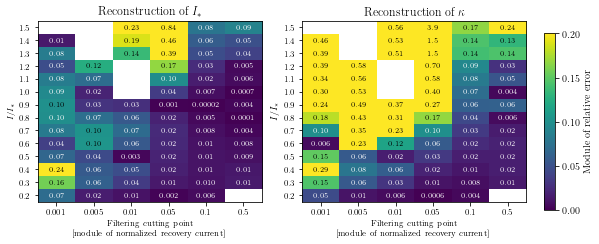

In [18]:
I_max_list = list(sorted([10.0, 12.000000000000002, 14.0, 16.0, 18.000000000000004, 20.0, 22.0, 24.0, 26.0, 28.000000000000004, 30.0, 4.0, 6.000000000000001, 8.0]))
b_step = 0.1
fraction = 0.5
f_list = [(np.inf, x) for x in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]]
f_bis = (1.0, 0.1)
fit_kind = "forward_only"

the_data_k = np.empty((len(I_max_list), len(f_list))) * np.nan
the_data_I = np.empty((len(I_max_list), len(f_list))) * np.nan

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))

for i, I_max in enumerate(I_max_list):
    for j, f in enumerate(f_list):
        tmp = full_dict[I_max][b_step][fraction]
        if f in tmp:
            if fit_kind in tmp[f] and type(tmp[f][fit_kind]) != str:
                the_data_I[i, j] = tmp[f][fit_kind].params["I_star"].value / 20.0 - 1
                the_data_k[i, j] = tmp[f][fit_kind].params["k"].value / 0.33 - 1

im = ax.imshow(
    np.absolute(the_data_I),
    origin="lower",
    aspect="auto", 
    vmin=vmin, vmax=vmax
)

ax.set_yticks(np.arange(0, len(the_data_I), 1))
ax.set_yticklabels(["{:.1f}".format(x / 20.0) for x in I_max_list], fontsize="small")
ax.set_xticks(np.arange(0, len(the_data_I[0]), 1))
ax.set_xticklabels(["{}".format(x[1]) for x in f_list], fontsize="small")

ax.set_xlabel(
    "Filtering cutting point\n[module of normalized recovery current]", fontsize="small")
ax.set_ylabel("$I / I_\\ast$", fontsize="small")
ax.set_title("Reconstruction of $I_\\ast$")

ax2.imshow(
    np.absolute(the_data_k),
    origin="lower", 
    aspect="auto", 
    vmin=vmin, vmax=vmax
)

ax2.set_yticks(np.arange(0, len(the_data_I), 1))
ax2.set_yticklabels(["{:.1f}".format(x/20.0) for x in I_max_list], fontsize="small")
ax2.set_xticks(np.arange(0, len(the_data_I[0]), 1))
ax2.set_xticklabels(["{}".format(x[1]) for x in f_list], fontsize="small")

ax2.set_xlabel("Filtering cutting point\n[module of normalized recovery current]", fontsize="small")
ax2.set_ylabel("$I / I_\\ast$")
ax2.set_title("Reconstruction of $\\kappa$")

for j in range(len(f_list)):
    for i in range(len(I_max_list)):
        ax.text(j, i, printer(
            the_data_I[i, j]), ha="center", va="center", color=color(the_data_I[i, j]), fontsize="x-small")

for j in range(len(f_list)):
    for i in range(len(I_max_list)):
        ax2.text(j, i, printer(
            the_data_k[i, j]), ha="center", va="center", color=color(the_data_k[i, j]), fontsize="x-small")

plt.tight_layout()
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
bar = fig.colorbar(im, cax=cbar_ax, label="Module of relative error")
bar.set_ticks([0.0, 0.05, 0.10, 0.15, 0.20])

plt.savefig(os.path.join(FIGPATH, "MULTI_different_filter.pdf"),
            dpi=600, bbox_inches='tight', pad_inches=0.0)
plt.savefig(os.path.join(FIGPATH, "MULTI_different_filter.png"),
            dpi=600, bbox_inches='tight', pad_inches=0.0, facecolor="white")
plt.savefig(os.path.join(FIGPATH, "MULTI_different_filter.jpg"),
            dpi=600, bbox_inches='tight', pad_inches=0.0)


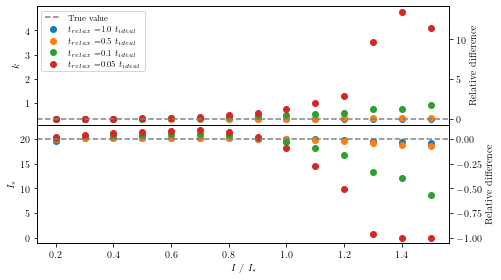

In [19]:
I_max = 8.0
b_step = 0.1
#fraction_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
fraction_list = [0.05, 0.1, 0.5, 1.0][::-1]
f = (np.inf, 0.1)
fit_kind = "forward_only"

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize)

ax_bis = ax.twinx()
ax2_bis = ax2.twinx()

for idx, fraction in enumerate(fraction_list):

    if idx == 0:
        true_data_x = []
    data_x = []
    data_k = []
    data_I = []

    tmp = full_dict
    for i in tmp:
        #print(i)
        if b_step in tmp[i]:
            if fraction in tmp[i][b_step]:
                if f in tmp[i][b_step][fraction]:
                    if fit_kind in tmp[i][b_step][fraction][f] and type(tmp[i][b_step][fraction][f][fit_kind]) != str:
                        #print("^^^in^^^")
                        if idx == 0:
                            true_data_x.append(i)
                        data_x.append(i)
                        data_k.append(tmp[i][b_step][fraction][f]
                                    [fit_kind].params["k"].value)
                        data_I.append(tmp[i][b_step][fraction][f]
                                    [fit_kind].params["I_star"].value)

    data_k = [x for _, x in sorted(zip(data_x, data_k))]
    data_I = [x for _, x in sorted(zip(data_x, data_I))]
    data_x = sorted(data_x)
    if idx == 0:
        true_data_x = sorted(true_data_x)

    ax.scatter(np.array(data_x)/20.0, data_k, label=r"$t_{relax} = $" + str(fraction) + r" $t_{ideal}$")

    mn, mx = ax.get_ylim()
    ax_bis.set_ylim(mn/0.33 - 1, mx/0.33 - 1)

    ax2.scatter(np.array(data_x)/20.0, data_I)

ax.axhline(0.33, c="grey", label="True value", linestyle="--")
ax2.axhline(20.0, c="grey", linestyle="--")

ax.legend(fontsize="small")

mn, mx = ax2.get_ylim()
ax2_bis.set_ylim(mn/20.0 - 1, mx/20.0 - 1)

ax2.set_xlabel("$I$ $/$ $I_\\ast$")
ax.set_ylabel("$k$")
ax2.set_ylabel("$I_\\ast$")
ax_bis.set_ylabel("Relative difference")
ax2_bis.set_ylabel("Relative difference")

#ax.set_title("Fit performance for different positions of the boundary")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax.get_xticklabels(), visible=False)

plt.savefig(os.path.join(
    FIGPATH, "MULTI_different_position_plot.pdf"), dpi=600, pad_inches=0.0)
plt.savefig(os.path.join(
    FIGPATH, "MULTI_different_position_plot.png"), dpi=600, pad_inches=0.0, facecolor="white")
plt.savefig(os.path.join(
    FIGPATH, "MULTI_different_position_plot.jpg"), dpi=600, pad_inches=0.0)


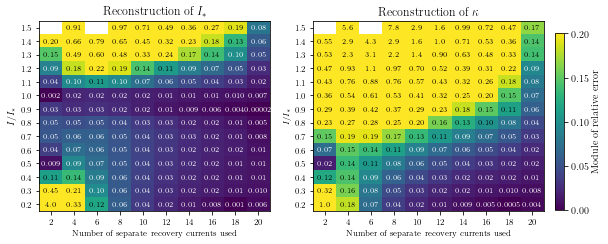

In [47]:
I_max_list = list(sorted([10.0, 12.000000000000002, 14.0, 16.0, 18.000000000000004,
                  20.0, 22.0, 24.0, 26.0, 28.000000000000004, 30.0, 4.0, 6.000000000000001, 8.0]))
b_step = 0.1
fraction = 0.5
f = (np.inf, 0.1)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8.0, 3.5))

the_data_I = np.empty((len(I_max_list), 20)) * np.nan
the_data_k = np.empty((len(I_max_list), 20)) * np.nan


for idx, I_max in enumerate(I_max_list):
    tmp = full_dict[I_max][b_step][fraction]
    for i in tmp:
        # print(i)
        if type(i) == int and f in tmp[i] and type(tmp[i][f]["forward_only"]) != str:
            the_data_I[idx, i-1] = tmp[i][f]["forward_only"].params["I_star"].value / 20.0 - 1
            the_data_k[idx, i-1] = tmp[i][f]["forward_only"].params["k"].value / 0.33 - 1
    the_data_I[idx, 19] = tmp[f]["forward_only"].params["I_star"].value / 20.0 - 1
    the_data_k[idx, 19] = tmp[f]["forward_only"].params["k"].value / 0.33 - 1

the_data_I = the_data_I[:, 1::2]
the_data_k = the_data_k[:, 1::2]

im = ax.imshow(np.absolute(the_data_I), origin="lower",
               aspect="auto", vmin=0.0, vmax=max_err)

ax.set_yticks(np.arange(0, len(the_data_I), 1))
ax.set_yticklabels(["{:.1f}".format(x / 20.0) for x in I_max_list], fontsize="small")
ax.set_xticks(np.arange(0, len(the_data_I[0]), 1))
ax.set_xticklabels(["{}".format(x) for x in np.arange(2, 21, 2)], fontsize="small")

ax.set_xlabel(
    "Number of separate recovery currents used", fontsize="small")
ax.set_ylabel("$I / I_\\ast$")
ax.set_title("Reconstruction of $I_\\ast$")

ax2.imshow(np.absolute(the_data_k), origin="lower",
           aspect="auto", vmin=0.0, vmax=max_err)

ax2.set_yticks(np.arange(0, len(the_data_I), 1))
ax2.set_yticklabels(["{:.1f}".format(x/20.0) for x in I_max_list], fontsize="small")
ax2.set_xticks(np.arange(0, len(the_data_I[0]), 1))
ax2.set_xticklabels(["{}".format(x) for x in np.arange(2, 21, 2)], fontsize="small")

ax2.set_xlabel("Number of separate recovery currents used", fontsize="small")
ax2.set_ylabel("$I / I_\\ast$", fontsize="small")
ax2.set_title("Reconstruction of $\\kappa$")


for j in range(10):
    for i in range(len(I_max_list)):
        ax.text(j, i, printer(
            the_data_I[i, j]), ha="center", va="center", color=color(the_data_I[i, j]), fontsize="x-small")

for j in range(10):
    for i in range(len(I_max_list)):
        ax2.text(j, i, printer(
            the_data_k[i, j]), ha="center", va="center", color=color(the_data_k[i, j]), fontsize="x-small")

plt.tight_layout()
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.015, 0.7])

bar = fig.colorbar(im, cax=cbar_ax, label="Module of relative error")
bar.set_ticks([0.0, 0.05, 0.10, 0.15, 0.20])

plt.savefig(os.path.join(FIGPATH, "MULTI_different_samples.pdf"), dpi=600, bbox_inches="tight", pad_inches=0.0)
plt.savefig(os.path.join(FIGPATH, "MULTI_different_samples.png"), dpi=600, bbox_inches="tight", pad_inches=0.0, facecolor="white")
plt.savefig(os.path.join(FIGPATH, "MULTI_different_samples.jpg"), dpi=600, bbox_inches="tight", pad_inches=0.0)


# OLD DICTIONARY STUFF

In [21]:
with open("working_experiment_script/full_dict_copy.pkl", 'rb') as f:
    full_dict = pickle.load(f)

In [22]:
print("Before deletion: ", full_dict.keys())
to_delete = []
for i in full_dict:
    if len(full_dict[i]) < 3:
        to_delete.append(i)
for i in to_delete:    
    del full_dict[i]
print("After deletion: ", full_dict.keys())

Before deletion:  dict_keys([10.0, 10.000000000000002, 12.000000000000002, 14.0, 14.000000000000004, 16.0, 16.000000000000007, 18.000000000000004, 20.0, 20.000000000000004, 22.0, 22.000000000000007, 24.0, 24.000000000000007, 26.0, 26.000000000000007, 28.000000000000004, 28.000000000000007, 30.0, 4.0, 6.000000000000001, 8.0, 8.000000000000002])
After deletion:  dict_keys([10.0, 12.000000000000002, 14.0, 16.0, 18.000000000000004, 20.0, 22.0, 24.0, 26.0, 28.000000000000004, 30.0, 4.0, 6.000000000000001, 8.0])


## Different relaxation times

In [25]:
figsize = (7, 4)
figsize_compressed = (7, 3)
figsize_compressed_half = (7, 3.5)
figsize_large = (7, 5)


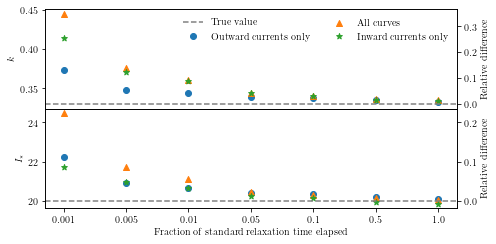

In [26]:
I_max = 8.0
b_step = 0.1
fraction = 0.5
f = (np.inf, 0.5)
f_bis = (1.0, 0.5)
fit_kind = "forward_only"

fig, (ax, ax2) = plt.subplots(
    2, 1, sharex=True, figsize=figsize_compressed_half)

ax_bis = ax.twinx()
ax2_bis = ax2.twinx()

data_x = []
data_k = []
data_I = []
data_x_all = []
data_k_all = []
data_I_all = []
data_x_back = []
data_k_back = []
data_I_back = []

tmp = full_dict[I_max][b_step]
for i in tmp:
    if fit_kind in tmp[i][f]:
        # print(i)
        data_x.append(i)
        data_x_all.append(i)
        data_x_back.append(i)
        data_k.append(tmp[i][f][fit_kind].params["k"].value)
        data_I.append(tmp[i][f][fit_kind].params["I_star"].value)
        if "all" in tmp[i][f_bis]:
            data_k_all.append(tmp[i][f_bis]["all"].params["k"].value)
            data_I_all.append(tmp[i][f_bis]["all"].params["I_star"].value)
        else:
            data_k_all.append(np.nan)
            data_I_all.append(np.nan)
        if "backward_only" in tmp[i][f_bis]:
            data_k_back.append(
                tmp[i][f_bis]["backward_only"].params["k"].value)
            data_I_back.append(
                tmp[i][f_bis]["backward_only"].params["I_star"].value)
        else:
            data_k_back.append(np.nan)
            data_I_back.append(np.nan)

data_k = [x for _, x in sorted(zip(data_x, data_k))]
data_I = [x for _, x in sorted(zip(data_x, data_I))]
data_x = sorted(data_x)

data_k_all = [x for _, x in sorted(zip(data_x_all, data_k_all))]
data_I_all = [x for _, x in sorted(zip(data_x_all, data_I_all))]
data_x_all = sorted(data_x_all)

data_k_back = [x for _, x in sorted(zip(data_x_back, data_k_back))]
data_I_back = [x for _, x in sorted(zip(data_x_back, data_I_back))]
data_x_back = sorted(data_x_back)

ax.axhline(0.33, c="grey", label="True value", linestyle="dashed")
ax.scatter(np.arange(len(data_k)), data_k, label="Outward currents only")
ax.scatter(np.arange(len(data_k_all)), data_k_all,
           marker="^", label="All curves")
ax.scatter(np.arange(len(data_k_back)), data_k_back,
           marker="*", label="Inward currents only")

ax.legend(ncol=2, frameon=False)

mn, mx = ax.get_ylim()
ax_bis.set_ylim(mn/0.33 - 1, mx/0.33 - 1)

ax2.axhline(20.0, c="grey", linestyle="dashed")
ax2.scatter(np.arange(len(data_I)), data_I)
ax2.scatter(np.arange(len(data_I_all)), data_I_all, marker="^")
ax2.scatter(np.arange(len(data_I_back)), data_I_back, marker="*")

mn, mx = ax2.get_ylim()
ax2_bis.set_ylim(mn/20.0 - 1, mx/20.0 - 1)

ax.set_xticks(np.arange(len(data_k)))
ax.set_xticklabels(data_x)

ax2.set_xlabel("Fraction of standard relaxation time elapsed")
ax.set_ylabel("$k$")
ax2.set_ylabel("$I_\\ast$")
ax_bis.set_ylabel("Relative difference")
ax2_bis.set_ylabel("Relative difference")

#ax.set_title("Fit performance for different elapsed relaxation times")

plt.tight_layout()
plt.subplots_adjust(hspace=.0)
plt.setp(ax.get_xticklabels(), visible=False)

plt.savefig(os.path.join(FIGPATH, "all_different_time.pdf"),
            dpi=600, pad_inches=0.0)
